## Inverse problems in image processing - TD 3
                                  
                                  e-mail: vasiliki.stergiopoulou@inria.fr
                                  date: 12/1/2022

In [84]:
import math

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import pywt
import scipy.io as sio
from scipy.linalg import circulant, toeplitz

pio.templates.default = "plotly_white"


Load the image "boats.png", rescale it to have values in the [0, 255] interval and display it. (similar to TD1)

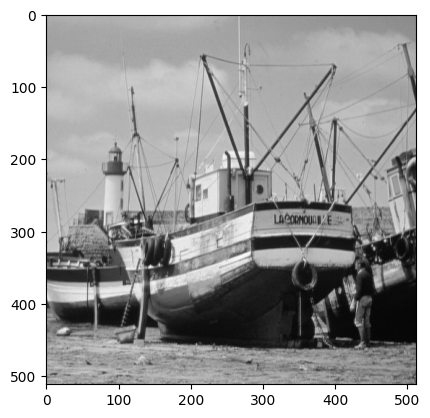

In [18]:
filename = "boats.png"
boats = plt.imread(filename)
boats = 255*boats
plt.imshow(boats, cmap='gray')


Compute the DWT of the image using the Haar wavelet ('haar') and the Daubechies' wavelets with 2 vanishing moments ('db2'). You can use the function dwt2() for the 2D Discrete Wavelet Transform:<br>
coeffs = pywt.dwt2(image,wavelet,mode='symmetric').<br>

coeffs[0] contains the approximation image in a coarser resolution ; coeffs[1] is the list of the 3 detail coefficients for scale j=1: horizontal detail, vertical detail and diagonal detail coefficients respectively. You can use instead: cA, (cH, cV, cD) = coeffs.

Plot the approximation image as well as the detail coefficients.

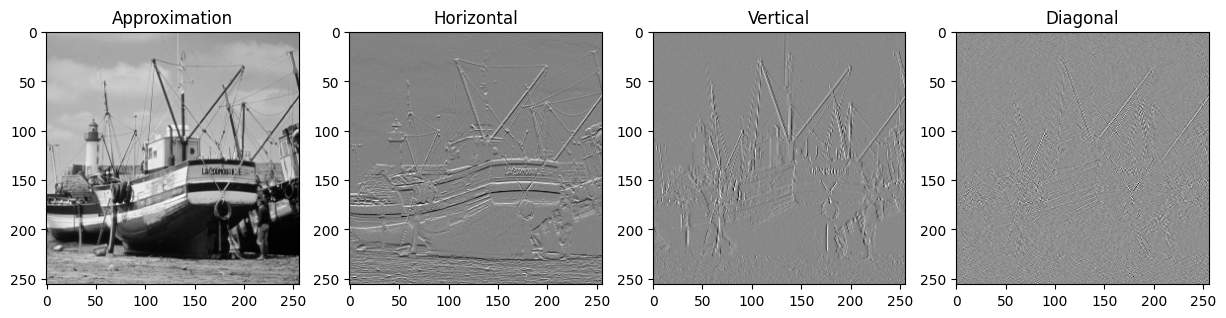

In [47]:
# Discrete Wavelet Transform
approx, (hor, ver, diag) = pywt.dwt2(boats, "haar")

def plot_dwt2(approx, hor, ver, diag):
  plt.figure(figsize=(15, 10))
  plt.subplot(1, 4, 1)
  plt.title("Approximation")
  plt.imshow(approx, cmap="gray")
  plt.subplot(1, 4, 2)
  plt.title("Horizontal")
  plt.imshow(hor, cmap="gray")
  plt.subplot(1, 4, 3)
  plt.title("Vertical")
  plt.imshow(ver, cmap="gray")
  plt.subplot(1, 4, 4)
  plt.title("Diagonal")
  plt.imshow(diag, cmap="gray")

  plt.show()
plot_dwt2(approx, hor, ver, diag)

Plot the absolute values of the coefficients, with zero value in white and high values in black

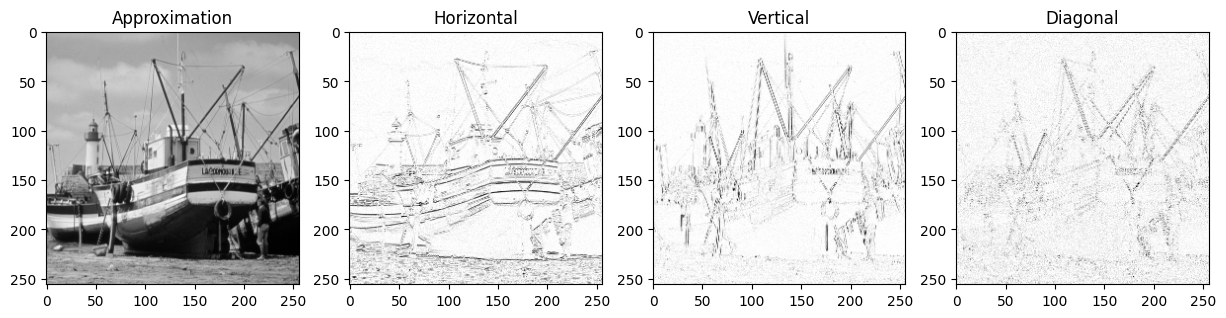

In [54]:
plot_dwt2(approx, -np.abs(hor), -np.abs(ver), -np.abs(diag))


Use the 2-D Inverse Discrete Wavelet Transform to reconstruct your image from the coefficient arrays:<br>
image = pywt.idwt2(coeffs,wavelet,mode='symmetric').
What do you observe? 


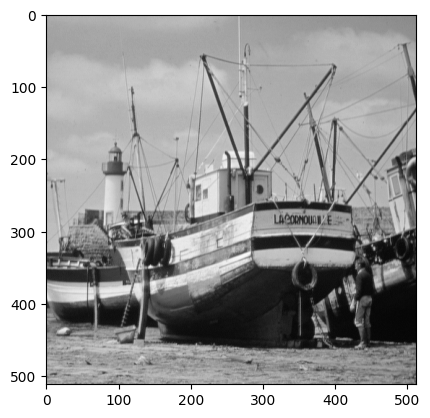

In [56]:
reconstruction = pywt.idwt2((approx, (hor, ver, diag)), "haar")
plt.imshow(reconstruction, cmap="gray")


You can zoom in the center to see better the details, e.g. you can use:<br>
x_zoom = x[N//2 - 32:N//2 + 32,N//2 - 32:N//2 + 32] where x is the image and NxN is the image size.

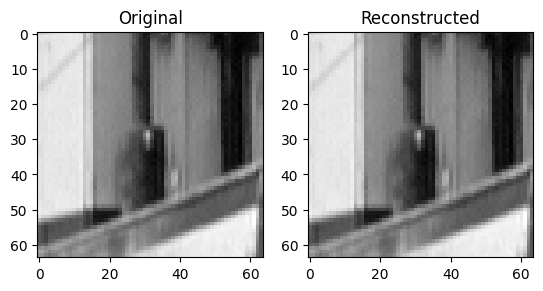

In [61]:
def zoom(img: np.ndarray, window: int = 64):
  side = len(img)
  zoomed_img = img[
    side // 2 - window // 2 : side // 2 + window // 2,
    side // 2 - window // 2 : side // 2 + window // 2,
  ]
  return zoomed_img

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(zoom(boats), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Reconstructed")
plt.imshow(zoom(reconstruction), cmap="gray")




Now, come back to the DWT of the image and set the 3 detail coefficient arrays to zero. Then, reconstruct your image using the 2-D Inverse Discrete Wavelet Transform. Plot the result and compare it with the original image. Plot also the zooms. What do you observe?

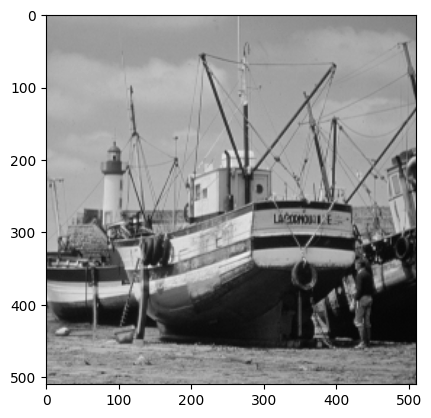

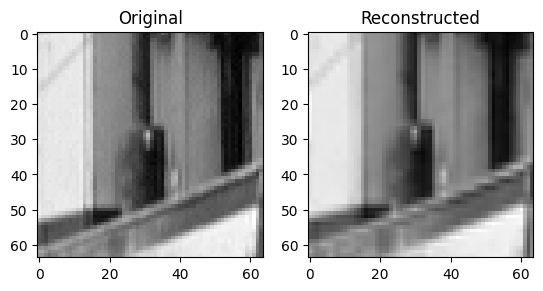

In [82]:
misreconstruction = pywt.idwt2((approx, 3*[np.zeros(hor.shape)]), "db2")
plt.imshow(misreconstruction, cmap="gray")
plt.show()

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(zoom(boats), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Reconstructed")
plt.imshow(zoom(misreconstruction), cmap="gray")

*Note:* We do indeed note some loss on the reconstruction quality.

Compute a **3-level** DWT of the image using the Daubechies' wavelets with 2 vanishing moments ('db2'). You can use the function wavedecn() for a Multilevel 2D Discrete Wavelet Transform:<br>
coeffs = pywt.wavedecn(image,wavelet,mode='symmetric',level).<br>

The variable "coeffs" is a list containing the resolution levels of the DWT. coeffs[0] contains the approximation image in a coarser resolution; coeffs[m] is the list of the 3 detail coefficients.  
You can use instead the list: [cAn, (cHn, cVn, cDn), … (cH1, cV1, cD1)]= coeffs.

Then plot the wavelet coefficients, but first concatenate all coefficients into a single array using: pywt.coeffs_to_array(coeffs).


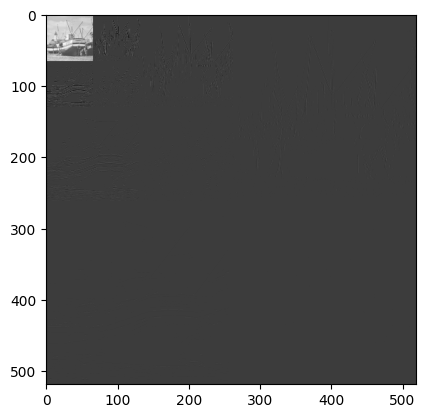

In [81]:
# DAUBECHIES 3 LEVELS
coeffs = pywt.wavedec2(boats,'db2',level=3) # mode periodic not symetric

#[cA3, (cH3, cV3, cD3),(cH2, cV2, cD2),(cH1, cV1, cD1)]=coeffs
arr, coeff_slices  = pywt.coeffs_to_array(coeffs)
plt.imshow(arr, cmap="gray")

Plot the histograms of the wavelet coefficients (approximation/detail coefficent arrays). What do you observe?  Where can the large coefficients be found? Which distribution describes the histogram of the detail coefficient arrays?  

To plot the histogram use: plt.hist(x, bins). If x is an array you can make it a vector by x.flatten(). The variable "bins" can be an integer and it defines the number of equal-width bins in the range.

In [174]:
fig = go.Figure()
for idx in range(1, 4):
  fig.add_trace(
    go.Histogram(
      x=np.concatenate(coeffs[idx]).flatten(),
      name=f"Level {4 - idx}",
      histnorm="probability",
      opacity=0.5,
    )
  )
fig.update_layout(barmode="overlay")

fig


# Linear wavelet approximation 

Let $B=\{e_m\}_{m\in N}$ an orthonormal basis of an Hilbert space $H$. For example $e_m= \psi_m$: a wavelet.  
All $u\in H$ can be decomposed on this basis as $$u = \sum_{m=0}^{+\infty}\langle u,e_m \rangle e_m$$

Rather than taking all coefficients, we reconstruct u with only M coefficients. We have an approximation of u:
$$u_M = \sum_{m=0}^{M}\langle u,e_m \rangle e_m$$

In this excercise the number M of kept coefficients is: $M = N^2/64$, where NxN is the size of the image. It is the same by computing a 3-level DWT and keeping only the approximation image in the coarser resolution. It corresponds to setting to zero all the coefficients excepted those that are on the upper left corner (of size $[\sqrt{M}, \sqrt{M}]$)of the array you will make using: <br>
arr, coeff_slices = pywt.coeffs_to_array(coeffs)

In order to come back to the spatial domain you will use first the function:<br>
coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices,output_format='wavedec2') that inverts a combined array of coefficients back to a list compatible with waverec2 and then:<br>
pywt.waverec2(coeffs_from_arr, "wavelet") the Multilevel 2D Inverse Discrete Wavelet Transform. You have to chose the same "wavelet" that you chose for the wavelet decomposition.

What do you observe if you compare the reconstructed image ($u_M$) and the original image ($u$) ?

In [167]:
n_coef_kept = len(boats)**2 / 64
n_coef_kept

4096.0

In [181]:
coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices, output_format="wavedec2")


# Non-linear wavelet approximation 

The linear approximation, that we saw before, projects a signal onto M orthogonal vectors selected a priori. 

This approximation is improved by choosing the M vectors according to each signal: this is the non-linear approximation.

The optimal choise is to keep the M largest wavelet coefficients:

$$u_M = \sum_{m \in I_M} \langle u,e_m \rangle e_m \quad\text{and}\quad I_M: \{\text{M largest coefficients} |<u, e_m>| \}$$


This is equivalently computed by a non-linear **hard thresholding**. The approximation is then: 
$$u = \sum_{m=0}^{+\infty}\theta_T^H \left(\langle u,e_m \rangle\right) e_m$$
where the hard thresholding function is given by:

$$        \theta_T^H (t) =
        \begin{cases}
        t, \quad\text{if}\quad |t|>T\\ 
        0, \quad\text{if}\quad |t|<T \\
        \end{cases} \quad \text{for threshold T s.t. } u^r(M+1)<T<u^r(M)
$$
where $u^r$ we note the ordered coefficients $(|\langle u, e_m \rangle|)_{m \in N}$. See slide 35 for more details.

However, it is not the purpose in this example to find a threshold that keeps exactly M coefficents. Just select a threshold (T) and play with it to observe the differences. 

Again you have to compute the wavelet coefficients (up to scale/level 3 for example), to arrange the wavelet coefficient list into an array using the function: pywt.coeffs_to_array(), to vanish the wavelet coefficients that are smaller than the threshold (T), to invert the combined array of coefficients back to a list using the function pywt.array_to_coeffs() and finaly to compute the 2D Inverse Discrete Wavelet Transform.

In [ ]:
# from numpy.testing import assert_array_almost_equal
coeffs = pywt.wavedec2(x1, 'db2',mode='periodization', level=3) #mode='periodization',
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
T = 200 #for M
arr = np.multiply(arr,(np.abs(arr) > T))
m = np.sum(arr != 0)
print('M/N = 1/%d'  %(512**2/m))
coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices,output_format='wavedec2')
y = pywt.waverec2(coeffs_from_arr,'db2', mode='periodization') #mode='periodization'
# print(assert_array_almost_equal(x1, y))

# plot the images
plt.figure(figsize=(8, 4), dpi=80)
plt.subplot(1,2,1)
plt.imshow(x1,cmap='gray') 
plt.subplot(1,2,2)
plt.imshow(y,cmap='gray') 
plt.show()

n0=512
plt.figure(figsize=(8, 4), dpi=80)
plt.subplot(1,2,1)
plt.title('zoom')
plt.imshow(x1[n0//2 - 32:n0//2 + 32,n0//2 - 32:n0//2 + 32],cmap='gray') 
plt.subplot(1,2,2)
plt.title('zoom')
plt.imshow(y[n0//2 - 32:n0//2 + 32,n0//2 - 32:n0//2 + 32],cmap='gray') 
plt.show()

# Image denoising 

Add white Gaussian noise to the image with standard deviation: σ = 20 (similarly to what we did in TD1).
Plot the original and the noisy image.

In [ ]:
sig = 20                     # SD of Gaussien noise
x1_n = x1 + sig*np.random.randn(np.shape(x1)[0],np.shape(x1)[1])
plt.figure(figsize=(16, 14), dpi=80)
plt.subplot(1,2,1)
plt.imshow(x1,cmap='gray') 
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(x1_n,cmap='gray') 
plt.title('Noisy')
plt.show()

Plot the histogram of the wavelet coefficients (approximation/detail coefficent arrays). What do you observe?

Denoise the image by non linear approximation: hard threshoding. Follow the same steps that we described before (excercise: Non-linear wavelet approximation). 

Which threshold will you use? (Hint: there is a relation with the standard deviation σ of the noise we added)

Is the image denoised?

In [ ]:
coeffs = pywt.wavedec2(x1_n, 'db2',mode='periodization', level=3) #mode='periodization',
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
T = 3*sig
arr = np.multiply(arr,(np.abs(arr) > T))
coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices,output_format='wavedec2')
y = pywt.waverec2(coeffs_from_arr,'db2', mode='periodization') #mode='periodization'

# plot the images
plt.figure(figsize=(8, 4), dpi=80)
plt.subplot(1,2,1)
plt.imshow(x1_n,cmap='gray') 
plt.subplot(1,2,2)
plt.imshow(y,cmap='gray') 
plt.show()

n0=512
plt.figure(figsize=(8, 4), dpi=80)
plt.subplot(1,2,1)
plt.title('zoom noisy')
plt.imshow(x1_n[n0//2 - 32:n0//2 + 32,n0//2 - 32:n0//2 + 32],cmap='gray') 
plt.subplot(1,2,2)
plt.title('zoom thresholded')
plt.imshow(y[n0//2 - 32:n0//2 + 32,n0//2 - 32:n0//2 + 32],cmap='gray') 
plt.show()



If you didn't know the standard deviation of the noise, what could you do? 
Try to estimate the standard deviation of the noise and compare it with the true one you have used. You can get some help from the slides.

In [ ]:
coeffs = pywt.wavedec2(x1_n, 'db2', level=1) #mode='periodization',
m = np.median(np.abs([coeffs[1][0],coeffs[1][1],coeffs[1][2]]))
print('sigma_est=', m//0.6745)

# Translation invariance 

A wavelet transform (with decimation) is not translation-invariant: the coefficients will not be the same for the image $u$ and for a shifted version of the image $u_s$. 

Please shift the image $u$ (e.g by one pixel in the horizontal/vertical direction). You have the image $u_s$. Then, find the non-linear approximation by applying hard thresholding to the wavelet coefficients. 

Do the same for the image $u$.  

Reverse the shifting for the non-linear approximation of the image $u_s$ that you compute. 

What do you observe? Are the two approximations the same? 


In [ ]:
coeffs = pywt.wavedec2(x1_n, 'db2',mode='periodization', level=3) #mode='periodization',
arr, coeff_slices = pywt.coeffs_to_array(coeffs)
T = 5*sig
arr = np.multiply(arr,(np.abs(arr) > T))
coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices,output_format='wavedec2')
y = pywt.waverec2(coeffs_from_arr,'db2', mode='periodization') #mode='periodization'

shift_x1_n = x1_n*0
shift_x1_n[1:,1:] = x1_n[:-1,:-1]

coeffs1 = pywt.wavedec2(shift_x1_n, 'db2',mode='periodization', level=3) #mode='periodization',
arr, coeff_slices = pywt.coeffs_to_array(coeffs1)
T = 5*sig
arr = np.multiply(arr,(np.abs(arr) > T))
coeffs_from_arr = pywt.array_to_coeffs(arr, coeff_slices,output_format='wavedec2')
y1 = pywt.waverec2(coeffs_from_arr,'db2', mode='periodization') #mode='periodization'

# plot the images
plt.figure(figsize=(8, 4), dpi=80)
plt.subplot(1,2,1)
plt.imshow(y,cmap='gray') 
plt.subplot(1,2,2)
plt.imshow(y1,cmap='gray') 
plt.show()

n0=512
plt.figure(figsize=(8, 4), dpi=80)
plt.subplot(1,2,1)
plt.title('zoom')
plt.imshow(y[n0//2 - 32:n0//2 + 32,n0//2 - 32:n0//2 + 32],cmap='gray') 
plt.subplot(1,2,2)
plt.title('zoom')
plt.imshow(y1[n0//2 - 32:n0//2 + 32,n0//2 - 32:n0//2 + 32],cmap='gray') 
plt.show()

n0=512
plt.figure(figsize=(8, 4), dpi=80)
plt.subplot(1,2,1)
plt.title('zoom')
plt.imshow(coeffs[1][0],cmap='gray') 
plt.subplot(1,2,2)
plt.title('zoom')
plt.imshow(coeffs1[1][0],cmap='gray') 
plt.show()